In [26]:
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from rbf_neural_networks import RBFExperiment, RBFNeuralNetwork
from sklearn.model_selection import StratifiedKFold

from scipy.spatial.distance import cdist
from matplotlib.lines import Line2D

In [27]:
def cross_validate_rbf(X, y, num_centers, n_splits=5):
    skf = StratifiedKFold(
        n_splits=n_splits,
        shuffle=True,
        random_state=42
    )

    accs = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        model = RBFNeuralNetwork(
            num_centers=num_centers,
        )

        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)

        acc = np.mean(y_pred == y_val)
        accs.append(acc)

    return np.mean(accs), np.std(accs)


K_list = [5, 10, 15, 20, 30, 40]


# 1 - IRIS Dataset

In [28]:
iris = load_iris()
X = iris.data
y = iris.target

X_train_iris, X_test_iris, y_train_iris, y_test_iris = train_test_split(X, y, test_size=0.2, random_state=42)

In [29]:
best_k_iris = None
best_score_iris = -np.inf

results = {}

for K in K_list:
    mean_acc, std_acc = cross_validate_rbf(
        X_train_iris, y_train_iris,
        num_centers=K
    )
    results[K] = (mean_acc, std_acc)
    print(f"K = {K} | Taux de reconnaissance = {mean_acc:.4f} ± {std_acc:.4f}")

    if mean_acc > best_score_iris:
        best_score_iris = mean_acc
        best_k_iris = K

print(f"Le meilleur K = {best_k_iris} avec Cross-Validation taux de reconnaissance = {best_score_iris:.4f}")

K = 5 | Taux de reconnaissance = 0.8917 ± 0.0425
K = 10 | Taux de reconnaissance = 0.8917 ± 0.0565
K = 15 | Taux de reconnaissance = 0.8833 ± 0.0486
K = 20 | Taux de reconnaissance = 0.9000 ± 0.0565
K = 30 | Taux de reconnaissance = 0.9000 ± 0.0425
K = 40 | Taux de reconnaissance = 0.9167 ± 0.0373
Le meilleur K = 40 avec Cross-Validation taux de reconnaissance = 0.9167


In [30]:
experiment_iris = RBFExperiment(
    data_name="Base d'IRIS",
    num_centers=best_k_iris,
    X_train=X_train_iris   ,
    y_train=y_train_iris,
    X_test=X_test_iris,
    y_test=y_test_iris,
)

In [31]:
experiment_iris.train()
experiment_iris.predict()

In [32]:
overall_train_acc_iris, class_train_acc_iris = experiment_iris.train_accuracy()

print(f"Taux d'apprentissage: {overall_train_acc_iris * 100:.2f}%")
for c, acc in class_train_acc_iris.items():
    print(f"Taux d'apprentissage de la classe {c}: {acc * 100:.2f}%")

Taux d'apprentissage: 93.33%
Taux d'apprentissage de la classe 0: 100.00%
Taux d'apprentissage de la classe 1: 92.68%
Taux d'apprentissage de la classe 2: 87.18%


In [33]:
overall_test_acc_iris, class_test_acc_iris = experiment_iris.test_accuracy()

print(f"Taux de reconnaissance: {overall_test_acc_iris * 100:.2f}%")
for c, acc in class_test_acc_iris.items():
    print(f"Taux de reconnaissance de la classe {c}: {acc * 100:.2f}%")

Taux de reconnaissance: 100.00%
Taux de reconnaissance de la classe 0: 100.00%
Taux de reconnaissance de la classe 1: 100.00%
Taux de reconnaissance de la classe 2: 100.00%


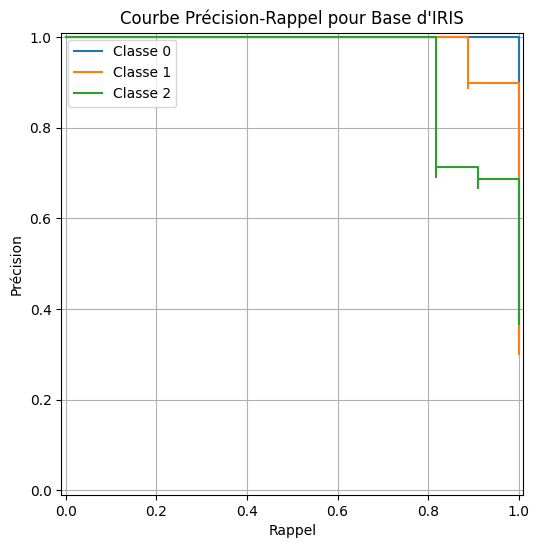

In [34]:
experiment_iris.plot_precision_recall_multiclass()

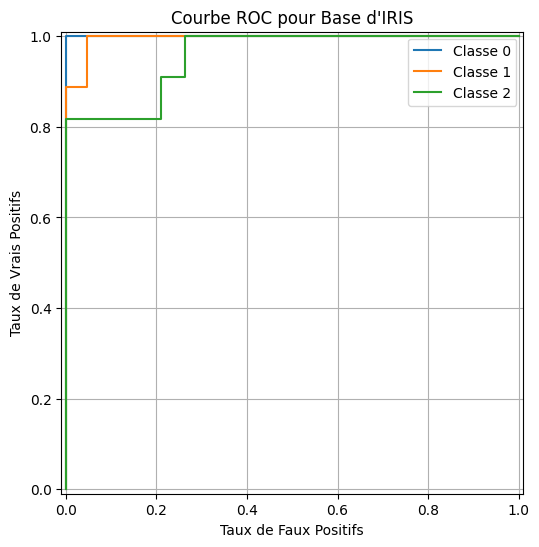

In [35]:
experiment_iris.plot_roc_multiclass()

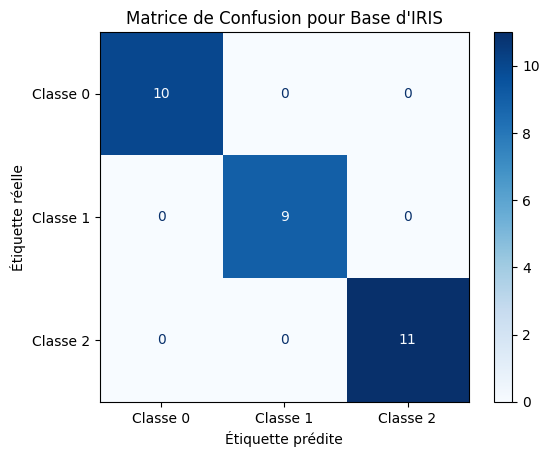

In [36]:
experiment_iris.plot_confusion_matrix()

In [37]:
X_train_2d = X_train_iris[:, 2:4]  # petal length & petal width
X_test_2d  = X_test_iris[:, 2:4]

experiment_iris_2d = RBFExperiment(
    data_name="Iris 2D",
    num_centers=best_k_iris,
    X_train=X_train_2d,
    y_train=y_train_iris,
    X_test=X_test_2d,
    y_test=y_test_iris,
    learning_rate=0.01,
    epochs=100
)

experiment_iris_2d.train()
experiment_iris_2d.predict()

centers = experiment_iris_2d.model.centers 
distances = cdist(centers, X_train_2d)
nearest_idx = np.argmin(distances, axis=1)
centers_labels = y_train_iris[nearest_idx]

x_min, x_max = X_train_2d[:, 0].min() - 0.5, X_train_2d[:, 0].max() + 0.5
y_min, y_max = X_train_2d[:, 1].min() - 0.5, X_train_2d[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                     np.linspace(y_min, y_max, 300))
grid = np.c_[xx.ravel(), yy.ravel()]

Z = experiment_iris_2d.model.predict(grid)
Z = Z.reshape(xx.shape)

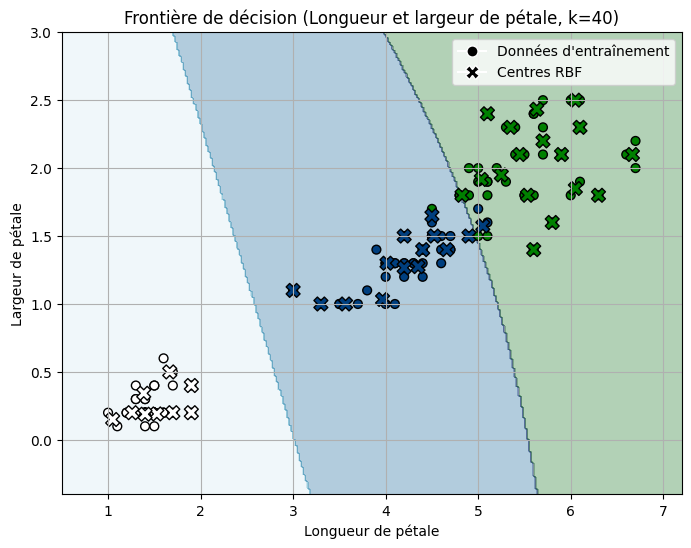

In [38]:
plt.figure(figsize=(8,6))

# Decision boundary
plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.ocean_r)

# Training points
plt.scatter(X_train_2d[:, 0], X_train_2d[:, 1], c=y_train_iris, cmap=plt.cm.ocean_r,
            edgecolor="k", s=40, label="Données d'entraînement")

# RBF centers
plt.scatter(centers[:, 0], centers[:, 1], c=centers_labels, cmap=plt.cm.ocean_r,
            s=100, marker="X", edgecolor="k", label="Centres RBF")
plt.xlabel("Longueur de pétale")
plt.ylabel("Largeur de pétale")
plt.title(f"Frontière de décision (Longueur et largeur de pétale, k={best_k_iris})")
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Données d\'entraînement',
           markerfacecolor='k', markersize=8),
    Line2D([0], [0], marker='X', color='w', label='Centres RBF',
           markerfacecolor='k', markersize=10)
]

plt.legend(handles=legend_elements)
plt.grid(True)
plt.show()

# 2 - Wine Dataset

In [39]:
file_name = "Wine dataset.csv"

data = np.loadtxt(file_name, delimiter=",", skiprows=1)
X_wine = data[:, 1:] 
y_wine = data[:, 0].astype(int) - 1  

X_train_wine, X_test_wine, y_train_wine, y_test_wine = train_test_split(
    X_wine, y_wine, test_size=0.2, random_state=42
)

In [40]:
best_k_wine = None
best_score_wine = -np.inf

results = {}

for K in K_list:
    mean_acc_wine, std_acc_wine = cross_validate_rbf(
        X_train_wine, y_train_wine,
        num_centers=K
    )
    results[K] = (mean_acc_wine, std_acc_wine)
    print(f"K = {K} | CV Accuracy = {mean_acc_wine:.4f} ± {std_acc_wine:.4f}")

    if mean_acc_wine > best_score_wine:
        best_score_wine = mean_acc_wine
        best_k_wine = K

print(f"Best K = {best_k_wine} with CV accuracy = {best_score_wine:.4f}")

K = 5 | CV Accuracy = 0.6475 ± 0.0415
K = 10 | CV Accuracy = 0.6687 ± 0.0708
K = 15 | CV Accuracy = 0.6899 ± 0.0287
K = 20 | CV Accuracy = 0.6828 ± 0.0260
K = 30 | CV Accuracy = 0.6823 ± 0.0495
K = 40 | CV Accuracy = 0.6823 ± 0.0544
Best K = 15 with CV accuracy = 0.6899


In [41]:
experiment_wine = RBFExperiment(
    data_name="Base de VIN",
    num_centers=best_k_wine,
    X_train=X_train_wine,
    y_train=y_train_wine,
    X_test=X_test_wine,
    y_test=y_test_wine,
    learning_rate=0.01,
    epochs=100
)

In [42]:
experiment_wine.train()
experiment_wine.predict()

In [43]:
overall_train_acc_wine, class_train_acc_wine = experiment_wine.train_accuracy()

print(f"Taux d'apprentissage: {overall_train_acc_wine * 100:.2f}%")
for c, acc in class_train_acc_wine.items():
    print(f"Taux d'apprentissage de la classe {c}: {acc * 100:.2f}%")

Taux d'apprentissage: 68.31%
Taux d'apprentissage de la classe 0: 88.89%
Taux d'apprentissage de la classe 1: 82.46%
Taux d'apprentissage de la classe 2: 25.00%


In [44]:
overall_test_acc_wine, class_test_acc_wine = experiment_wine.test_accuracy()

print(f"Taux de reconnaissance: {overall_test_acc_wine * 100:.2f}%")
for c, acc in class_test_acc_wine.items():
    print(f"Taux de reconnaissance de la classe {c}: {acc * 100:.2f}%")

Taux de reconnaissance: 75.00%
Taux de reconnaissance de la classe 0: 100.00%
Taux de reconnaissance de la classe 1: 78.57%
Taux de reconnaissance de la classe 2: 25.00%


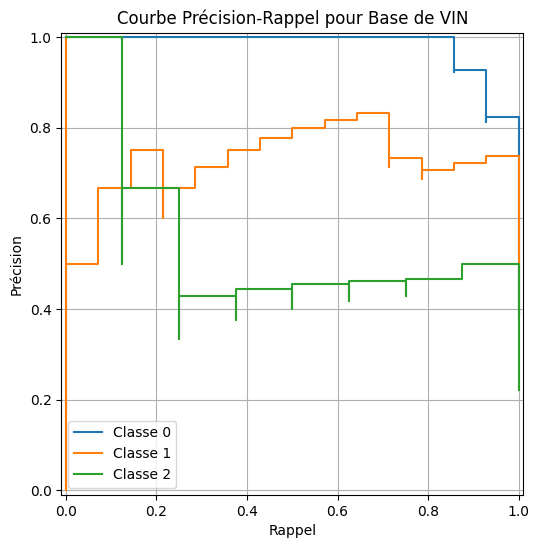

In [45]:
experiment_wine.plot_precision_recall_multiclass()

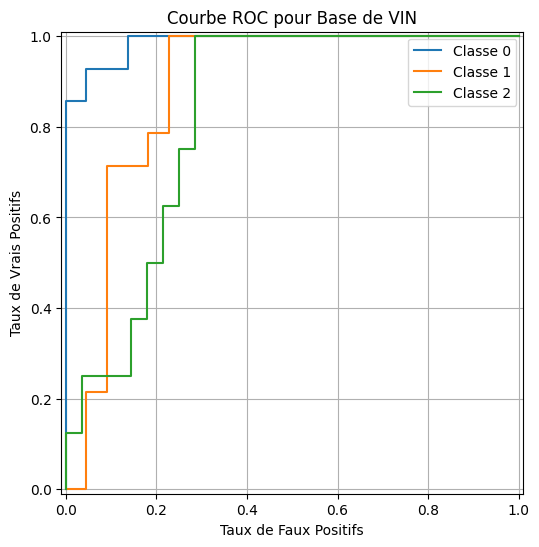

In [46]:
experiment_wine.plot_roc_multiclass()

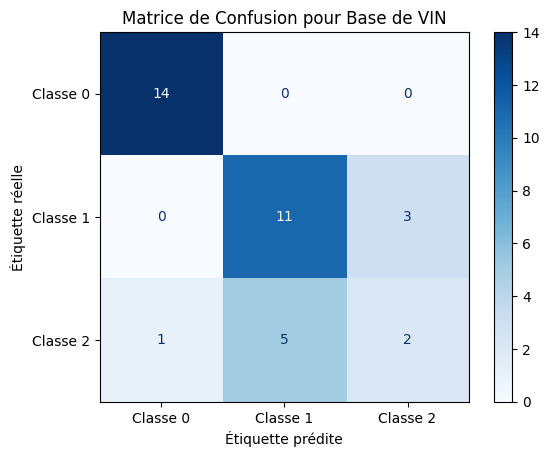

In [47]:
experiment_wine.plot_confusion_matrix()

# 3 - Generated data

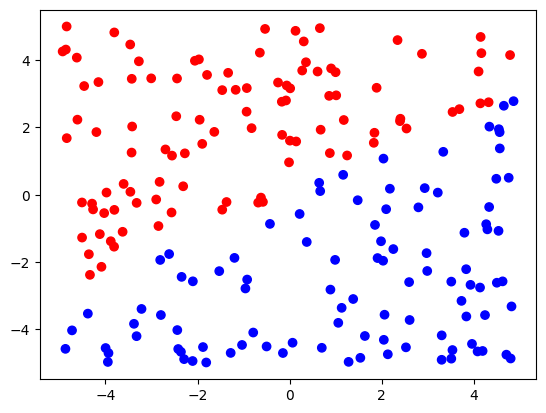

In [74]:
import numpy as np
import matplotlib.pyplot as plt

n_samples = 200
X = np.random.uniform(-5, 5, size=(n_samples, 2))

y = (X[:, 1] > 0.6 * X[:, 0]).astype(int)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap="bwr")
plt.show()

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

experiment = RBFExperiment(
    data_name="Base générée",
    num_centers=20,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
)

In [77]:
experiment.train()
experiment.predict()

In [78]:
centers = experiment.model.centers 
distances = cdist(centers, X_train)
nearest_idx = np.argmin(distances, axis=1)
centers_labels = y_train[nearest_idx]

x_min, x_max = X_train[:, 0].min() - 0.5, X_train[:, 0].max() + 0.5
y_min, y_max = X_train[:, 1].min() - 0.5, X_train[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                     np.linspace(y_min, y_max, 300))
grid = np.c_[xx.ravel(), yy.ravel()]

Z = experiment.model.predict(grid)
Z = Z.reshape(xx.shape)

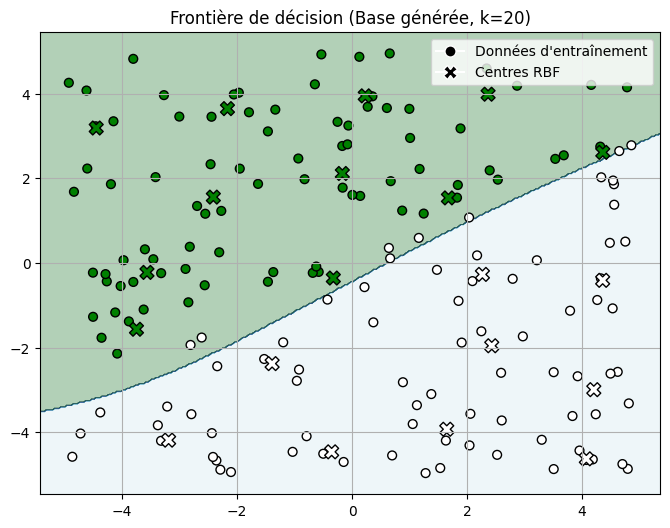

In [79]:
plt.figure(figsize=(8,6))

# Decision boundary
plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.ocean_r)

# Training points
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.ocean_r,
            edgecolor="k", s=40, label="Données d'entraînement")

# RBF centers
plt.scatter(centers[:, 0], centers[:, 1], c=centers_labels, cmap=plt.cm.ocean_r,
            s=100, marker="X", edgecolor="k", label="Centres RBF")
# plt.xlabel("Longueur de pétale")
# plt.ylabel("Largeur de pétale")
plt.title(f"Frontière de décision (Base générée, k=20)")
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Données d\'entraînement',
           markerfacecolor='k', markersize=8),
    Line2D([0], [0], marker='X', color='w', label='Centres RBF',
           markerfacecolor='k', markersize=10)
]

plt.legend(handles=legend_elements)
plt.grid(True)
plt.show()